##0. Imports

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
!pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, fbeta_score, make_scorer, classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from feature_engine.creation import CyclicalFeatures
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import optuna

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import tqdm
import copy
from torchvision.io import read_image
import os
from torchmetrics import Accuracy
from torchsummary import summary

In [ ]:
SEED = 22
sns.set(rc={"figure.figsize":(12, 8)})


I'll try to fix seed to get simmilar results every time.

In [ ]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(12)

Next chapter was copied from previous HW.

## 1. Data preparation and ML solution

### Initial data preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/hw4/dataset_57_hypothyroid.csv', na_values='?')

In [ ]:
print(df.isnull().sum())

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

In [ ]:
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
T

Most of the types are jbect which is obviously incorrect so i'll convert them to numerical types.

In [ ]:
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].apply(pd.to_numeric)
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
T

In [ ]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


'TBG' colum is completely nan so i'll drop it.

In [ ]:
df = df.drop('TBG', axis=1)

In [ ]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


From above table i see that there are some obvious outlier like age of 455 years. I'll change it to nan.


In [ ]:
df.loc[df[df['age']>150].index, 'age'] = np.nan

In [ ]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3770.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000
mean,51.628912,5.086766,2.013500,108.319345,0.995000,110.469649
std,18.982990,24.521470,0.827434,35.604248,0.195457,33.089698
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,94.000000,530.000000,10.600000,430.000000,2.320000,395.000000


#### EDA

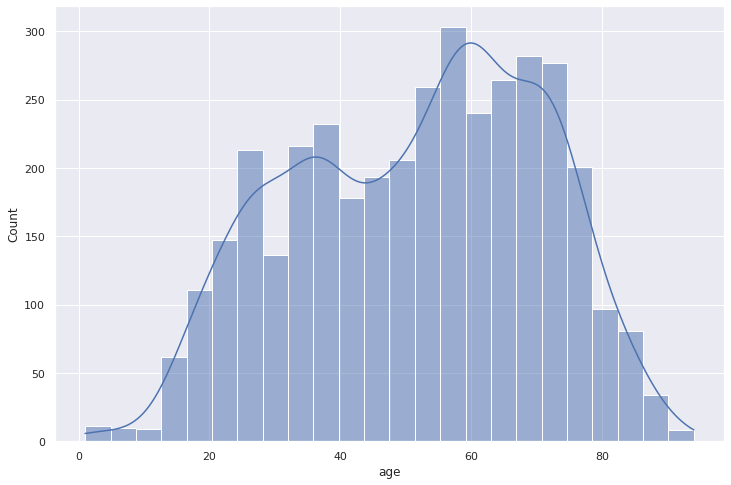

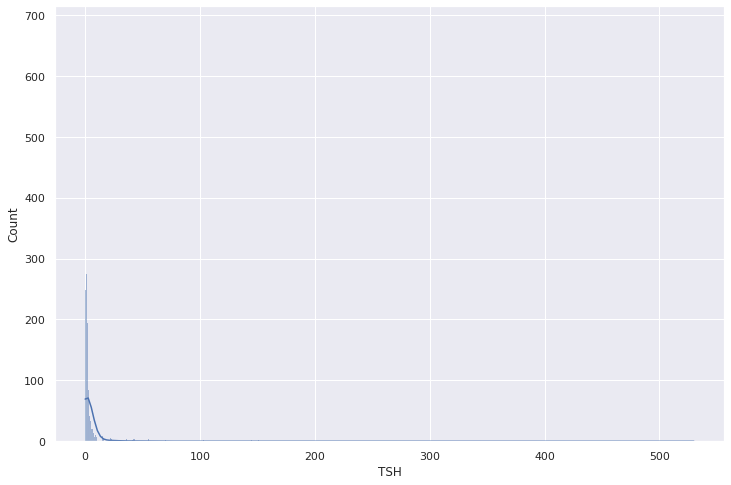

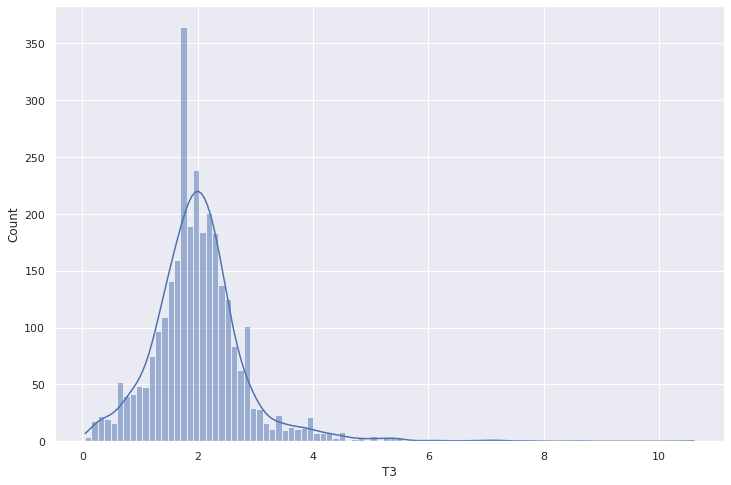

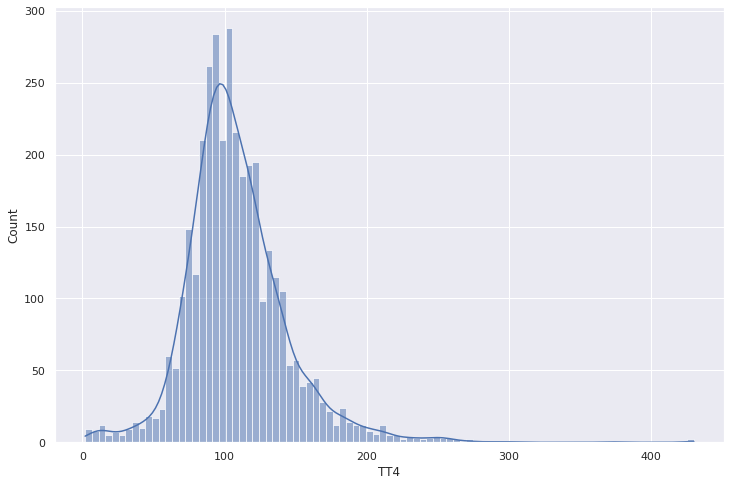

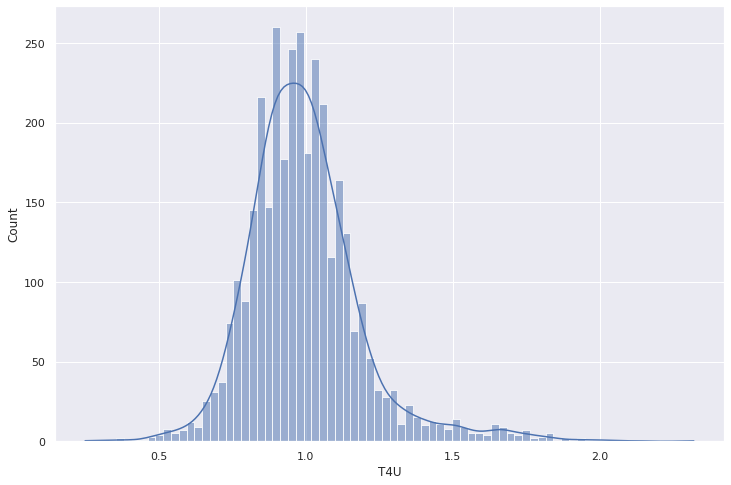

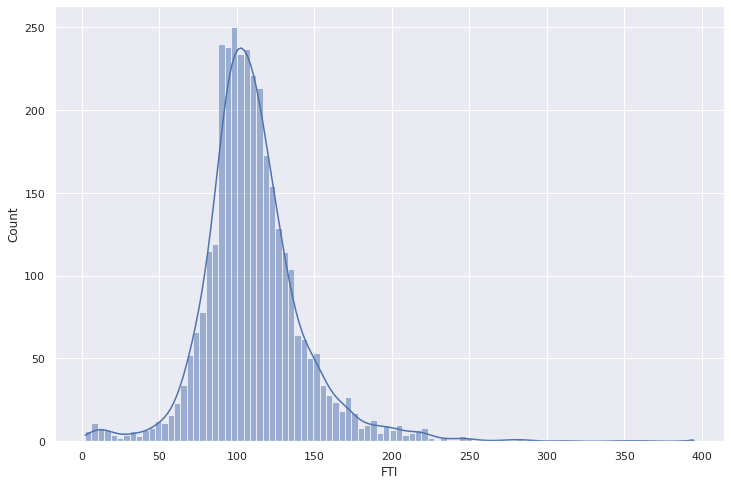

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
for column in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  sns.histplot(df[column], kde=True)
  plt.show()

Most columns seem to be normally-like disributed. The exception is TSH as it looks like exponential distribution.

Multivariative analysis

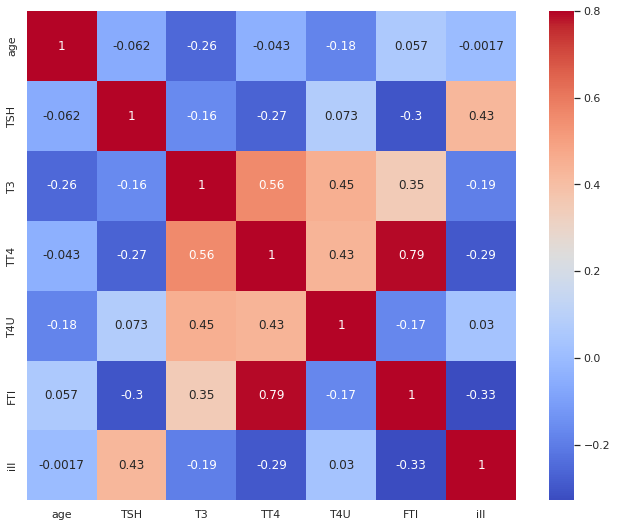

In [ ]:
df['ill'] = df['Class'].apply(lambda x: 0 if x == 'negative' else 1)
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="coolwarm", vmax=.8, square=True, annot=True);
df.drop('ill', axis=1, inplace=True)

I've added additional bool column 'ill' which has value 1 for all ill classes and 0 for 'negative' to investigate correlation with target value. There aren't columns with huge correlation but 'FTI', 'TT4' and 'TSH' seem to be the most significant. Columns FTI and TT4 have very high correlation - 0.79.

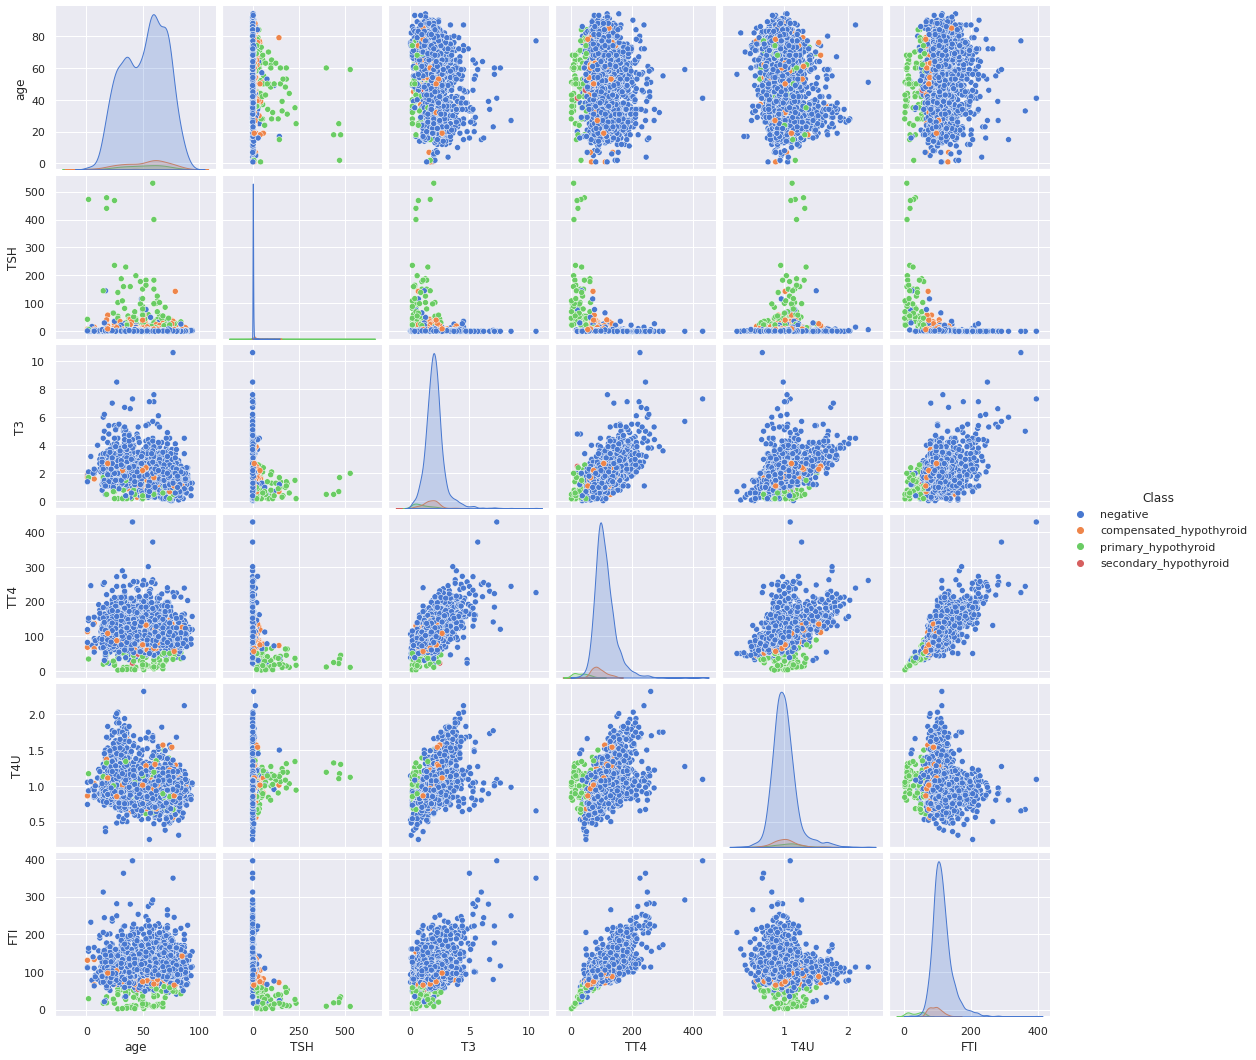

In [ ]:
sns.pairplot(df, hue='Class', palette='muted')

Paiplots ilustrate corrmap. FTI, TSH and FT4 seem to be the most related to target. FTI and TT4 indeed are very correlated, especially when the values are low but after that correlation decreses so i dont't think there is sense in dropping one of them.

referral_source is the only non-binary categorical feature so i'd like to know wheter there is link between target and this feature

<Axes: xlabel='referral_source', ylabel='Percent'>

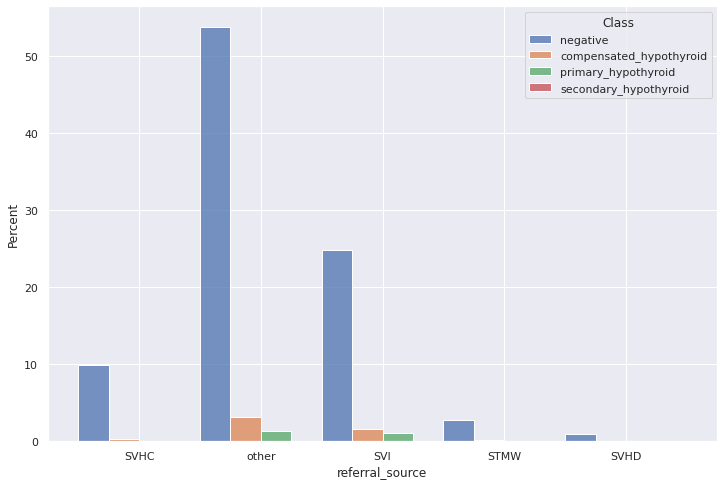

In [ ]:
sns.histplot(df, x='referral_source', hue='Class', multiple="dodge", stat='percent')

From above plot i dont see much link between target and referral_source. As there is no inner order between diffrent kinds of sourses i'd have to perform one-hot encoding and that would increase number of dimentions by 5. I think it is not that necessecery feature so i'll drop it.

### Data preprocessing

#### Missing values

Firstly, let's see how much data is missing

In [ ]:
df.isnull().sum()/len(df)

age                          0.000530
sex                          0.039767
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
query_hyperthyroid           0.000000
lithium                      0.000000
goitre                       0.000000
tumor                        0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
TSH                          0.097826
T3_measured                  0.000000
T3                           0.203871
TT4_measured                 0.000000
TT4                          0.061241
T4U_measured                 0.000000
T4U                          0.102598
FTI_measured                 0.000000
FTI                          0.102068
TBG_measured

Most columns that contain missing data don't have more then 10 % missing. Only one column - T3 misses 20%. Let's find out if missing columns are all the same.

In [ ]:
missing = df[df[['TSH', 'T3', 'TT4', 'T4U', 'FTI']].isnull().all(axis=1)]
missing

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
39,64.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
66,69.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
72,59.0,F,f,f,f,t,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
92,26.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
104,57.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,51.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3745,59.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3752,71.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3763,41.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative


Yes, 179 rows don't contain any numerical info apart from age. let's find out if all other columns are also the same.

In [ ]:
missing[missing.duplicated(df.columns.drop('age'), keep=False)]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
39,64.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
66,69.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
72,59.0,F,f,f,f,t,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
92,26.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
104,57.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,51.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3745,59.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3752,71.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
3763,41.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative


167 of them are duplicates so those i certainly drop

In [ ]:
df.drop_duplicates(df.columns.drop('age'), inplace=True)

In [ ]:
missing = df[df[['TSH', 'T3', 'TT4', 'T4U', 'FTI']].isnull().all(axis=1)]
missing

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
39,64.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
72,59.0,F,f,f,f,t,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
150,17.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
231,70.0,M,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
443,41.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
512,65.0,F,f,f,f,t,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
622,64.0,F,t,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
685,63.0,NaN,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative
700,25.0,M,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,SVHC,negative
726,41.0,F,t,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,other,negative


Other 26 rows are all have negative class (the most frequent one) and are also highly duplicative so i'll drop them too.

In [ ]:
df.dropna(how='all', subset=['TSH', 'T3', 'TT4', 'T4U', 'FTI'], inplace=True)

In [ ]:
df.Class.value_counts()

negative                   3294
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
df.isnull().sum()/len(df)

age                          0.000558
sex                          0.040167
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
query_hyperthyroid           0.000000
lithium                      0.000000
goitre                       0.000000
tumor                        0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
TSH                          0.051325
T3_measured                  0.000000
T3                           0.164575
TT4_measured                 0.000000
TT4                          0.012831
T4U_measured                 0.000000
T4U                          0.056346
FTI_measured                 0.000000
FTI                          0.055788
TBG_measured

### Data transformations

Most of the distributions are severely skewed so i'll try some transformations on them.

In [ ]:
num_cols = ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI')
res = [[st.normaltest(np.log(df[col]), nan_policy='omit') for col in num_cols]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=num_cols)
norm_h0

[[NormaltestResult(statistic=1571.68765338349, pvalue=0.0), NormaltestResult(statistic=218.2224477522723, pvalue=4.1076890177336965e-48), NormaltestResult(statistic=1189.8660120392515, pvalue=4.206088278774304e-259), NormaltestResult(statistic=2278.025040579305, pvalue=0.0), NormaltestResult(statistic=243.17285411819282, pvalue=1.5692265734261836e-53), NormaltestResult(statistic=2600.0407503970373, pvalue=0.0)]]


,age,TSH,T3,TT4,T4U,FTI
0,"(1571.68765338349, 0.0)","(218.2224477522723, 4.1076890177336965e-48)","(1189.8660120392515, 4.206088278774304e-259)","(2278.025040579305, 0.0)","(243.17285411819282, 1.5692265734261836e-53)","(2600.0407503970373, 0.0)"


In [ ]:
res = [[st.normaltest(df[col], nan_policy='omit') for col in num_cols]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=num_cols)
norm_h0

[[NormaltestResult(statistic=509.4836610523055, pvalue=2.3282450728850186e-111), NormaltestResult(statistic=6317.299964783477, pvalue=0.0), NormaltestResult(statistic=1281.283371012964, pvalue=5.927220820727865e-279), NormaltestResult(statistic=1076.7355223344223, pvalue=1.5482892216320525e-234), NormaltestResult(statistic=865.0220675056678, pvalue=1.4549386431045578e-188), NormaltestResult(statistic=1134.316352555169, pvalue=4.856614993979019e-247)]]


,age,TSH,T3,TT4,T4U,FTI
0,"(509.4836610523055, 2.3282450728850186e-111)","(6317.299964783477, 0.0)","(1281.283371012964, 5.927220820727865e-279)","(1076.7355223344223, 1.5482892216320525e-234)","(865.0220675056678, 1.4549386431045578e-188)","(1134.316352555169, 4.856614993979019e-247)"


Those hypothesis tests are do not give much info so i'll make qqplots to visually analize data.

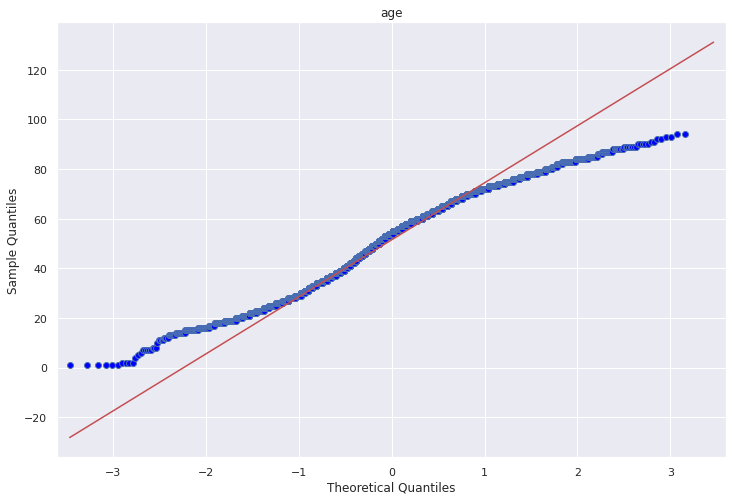

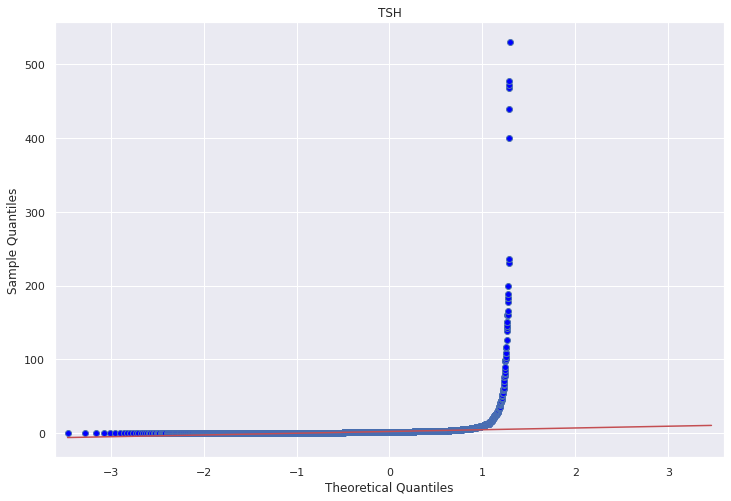

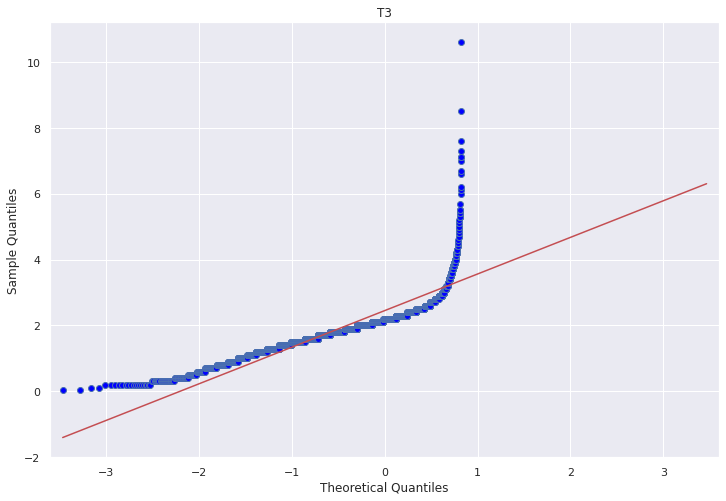

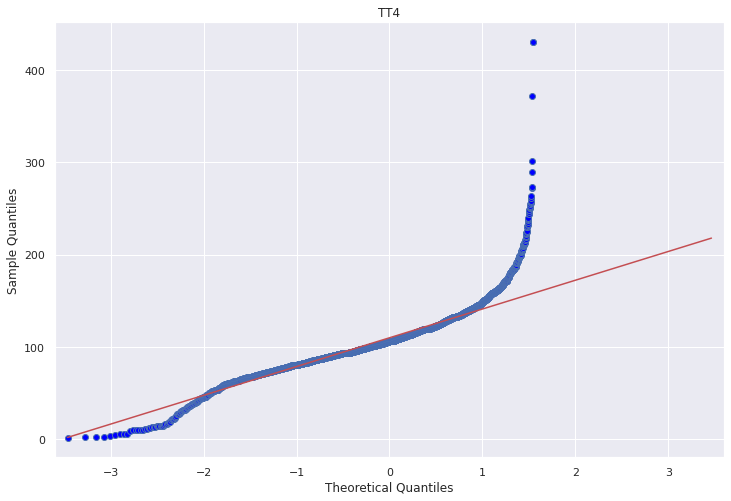

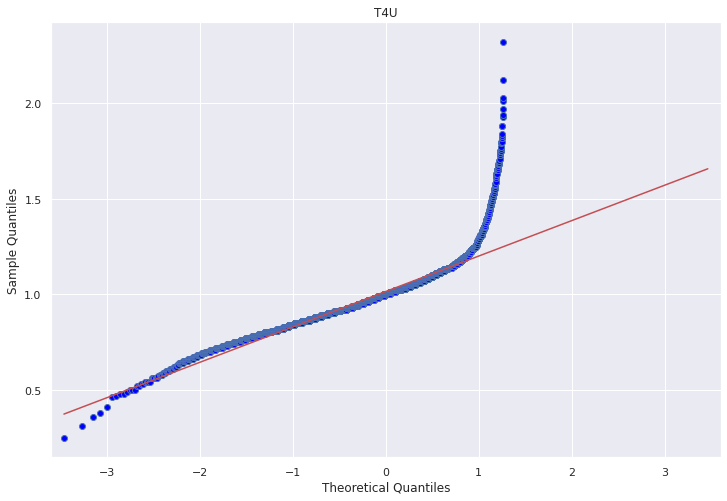

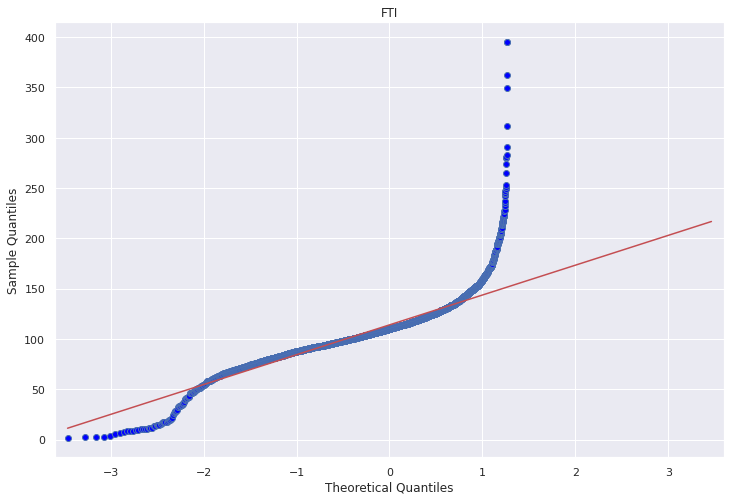

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(df[col], line='q')
  plt.title(col)
  plt.show()

From above qqplots i see that most columns have a very long right tail and only 'age is really close to be normal. Let's tru log transformation

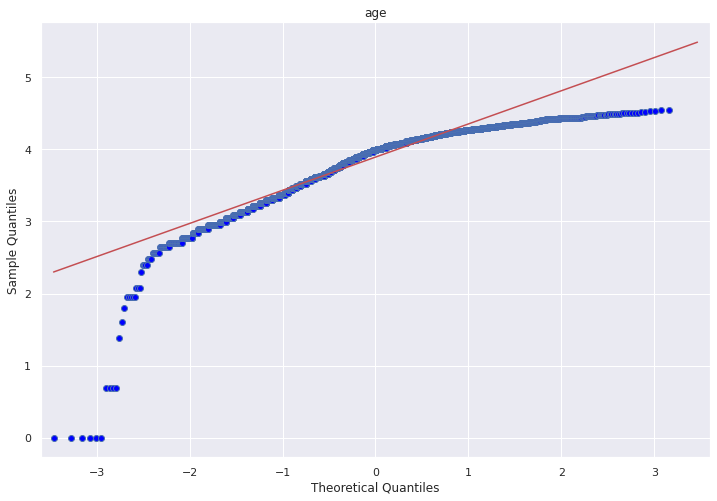

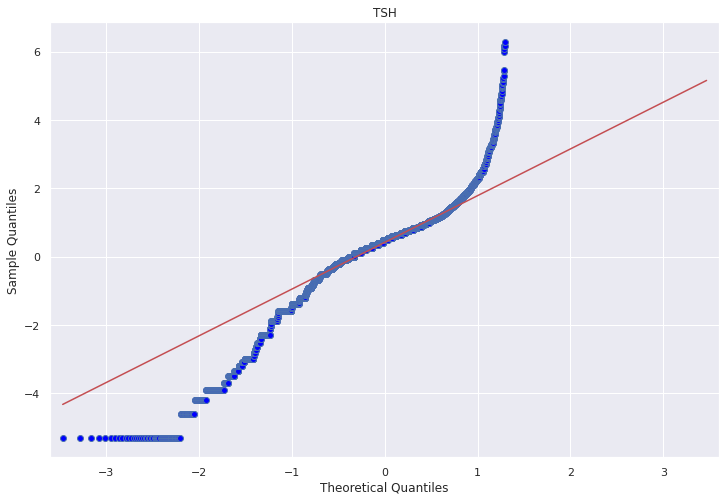

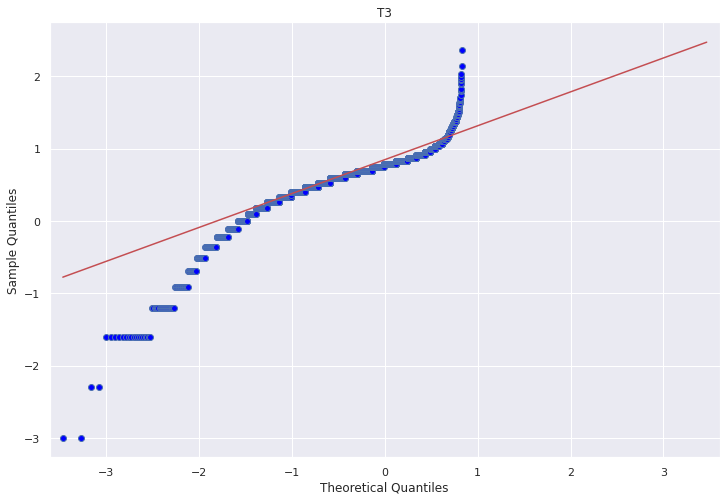

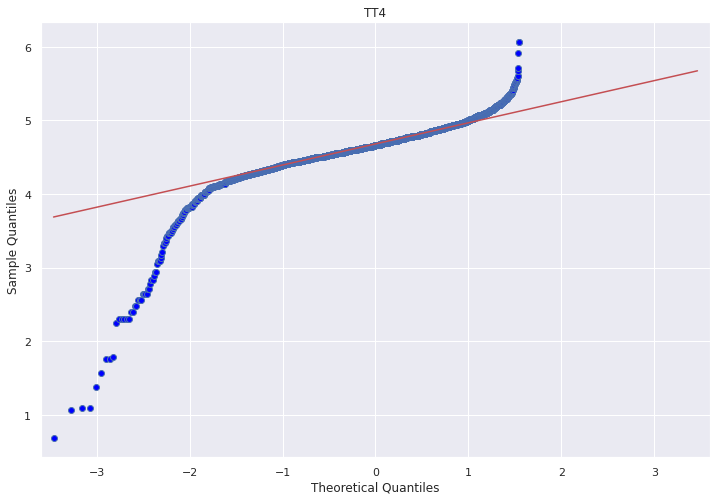

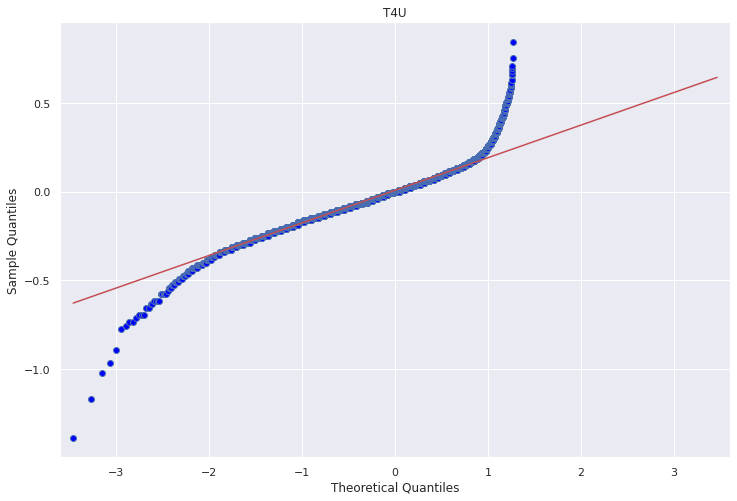

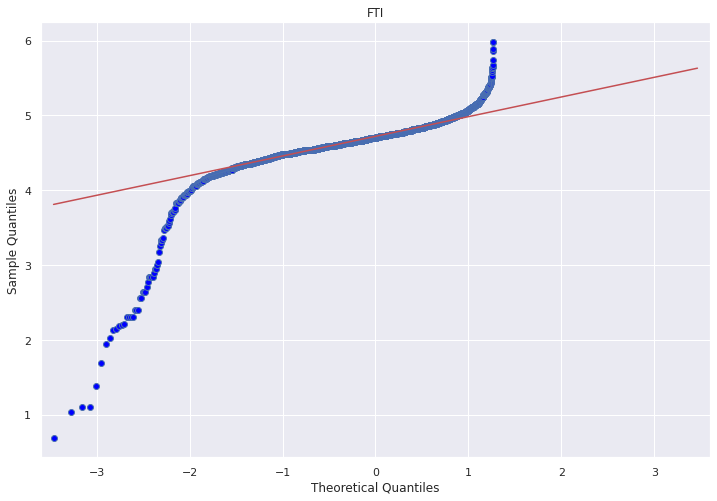

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(np.log(df[col]), line='q')
  plt.title(col)
  plt.show()

Log didn't really solve the problem as we still have problem with right tails but now little values are also smaller then they theoretically need to be. I'll try a bit softer sqrt transformation.

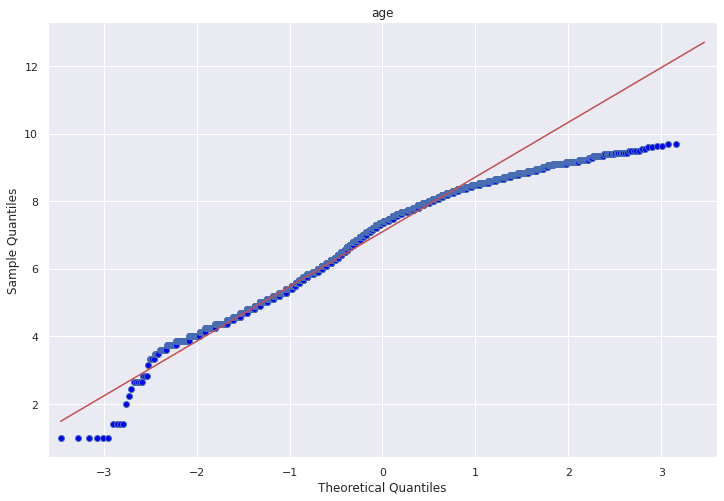

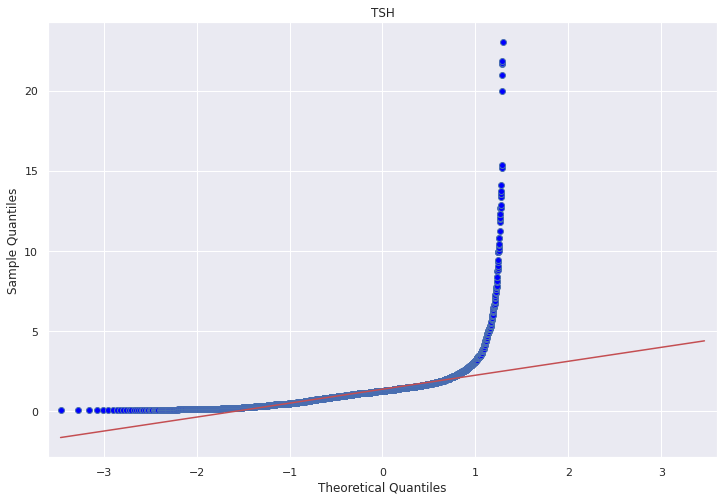

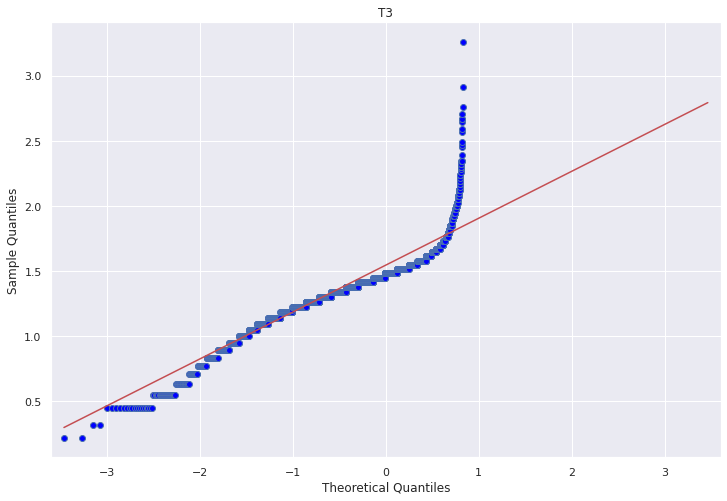

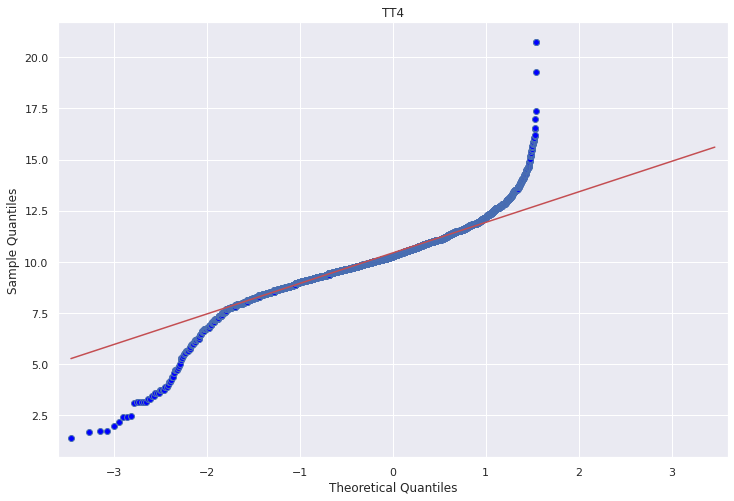

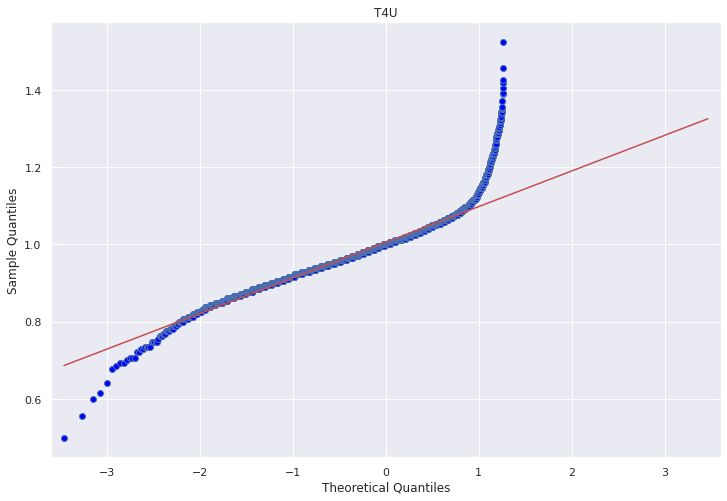

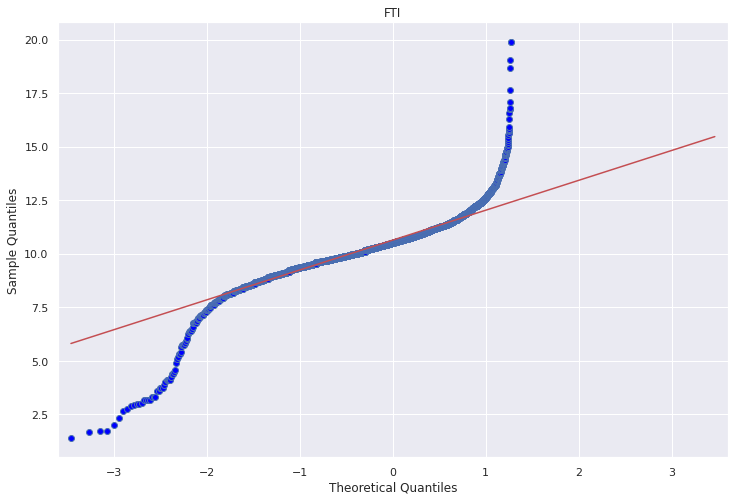

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(np.sqrt(df[col]), line='q')
  plt.title(col)
  plt.show()

Although the data is still not quite normally distributed, sqrt seem to be better then both log and untransformed data.

In [ ]:
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = np.sqrt(df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']])

### Pipeline

All the remaining missing data i'm going to impute using KNNImputer after I encode categorical data so that categorical data was also used to make more accurate imputing. All the "_measure" columns that show wheather there is numerical feature or not are redundant as they only tell us if the value was imputed and they significantly increase dimentions, so i'll drop them. As i've mentioned earlier, i'll drop referral_source feature. In fact, i also have an idea of dropping 2 rows that represent 4 class which i am not sure about. On one hand, our model is about classifing illnesses so the risk of misclassifing a severy ill person is very high. One the other hand, 2 istances is clearly not enough to catch the pattern, especially if one of them is in train and other is in test set. All in all, i'm going to drop them in order to use macro avaraging to give all the remaining classes equall importance as I think this case correctly classifing ill people is more important then correctly classifing the healthy (if we had 2 classes - recall would have been more important then precision).

In [ ]:
df = df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'FTI_measured', 'TBG_measured', 'referral_source'], axis=1)
df = df.drop(df[df['Class'] == 'secondary_hypothyroid'].index)

To perform all necessary transformation i'm going to use pipeline which will contain OrdinalEncoder, KNNImputer and StandardScaler.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], random_state=SEED, shuffle=True, stratify=df['Class'])
encode = ColumnTransformer([('encoder', OrdinalEncoder(), X_train.select_dtypes(exclude='number').columns)], remainder='passthrough')
pipe = Pipeline([('encode', encode), ('imputer', KNNImputer()), ('scaler', StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

### ML models

As the data is not time-series i can use default cv and shuffle to tune hyperparametrs. As target value is very unbalanced('negative' values is about 90%) we can't use default accuracy and i'm going to use f2 score - harmonic average of precision and recall with more importance to recall. As i don't know how the model would be used i cannot make fully valid desicion on what type of averaging to use. Intuitively, all of our classes should be equaly important as it might be very dangerous to misclassify an ill person as healthy. At the same time, our classes are imbalanced and it will be unadequate to give all classes exactly equall weight so i'll use both macro and weighted averaging for scoring but will use macro averaging for hyperparameters tuning.

In [ ]:
def evaluate(y_true, X, model):
  f2score = fbeta_score(y_true, model.predict(X), beta=2, average='macro')
  print(f'F2 score = {f2score}')
  report = classification_report(y_true, model.predict(X), digits=3)
  print('Classification Report:')
  print(report)
  return report, f2score


First, let's try baseline logistic regression model

In [ ]:
log_model = LogisticRegression().fit(X_train, y_train)
evaluate(y_test, X_test, log_model);

F2 score = 0.7144177043143438
Classification Report:
              precision    recall  f1-score   support

           0      0.722     0.271     0.394        48
           1      0.957     0.994     0.975       824
           2      0.909     0.833     0.870        24

    accuracy                          0.951       896
   macro avg      0.863     0.699     0.746       896
weighted avg      0.943     0.951     0.941       896



as a pinncale of classification methods, I'll use catboost classifier.

In [ ]:
clf = CatBoostClassifier(random_state=SEED, verbose=False)
cat_clf = clf.fit(X_train, y_train)

In [ ]:
evaluate(y_test, X_test, cat_clf);

F2 score = 0.9334768061843096
Classification Report:
              precision    recall  f1-score   support

           0      0.840     0.875     0.857        48
           1      0.994     0.989     0.991       824
           2      0.885     0.958     0.920        24

    accuracy                          0.982       896
   macro avg      0.906     0.941     0.923       896
weighted avg      0.983     0.982     0.982       896



It gives nearly perfect results.

In [ ]:
def conf_matrix(y, predictions, title):
  conf = confusion_matrix(y, predictions, normalize='true')
  sns.heatmap(conf,
              annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
              yticklabels=np.unique(y),
              xticklabels=np.unique(y));
  plt.title(title);
  plt.xlabel('Predicted label');
  plt.ylabel('True label');

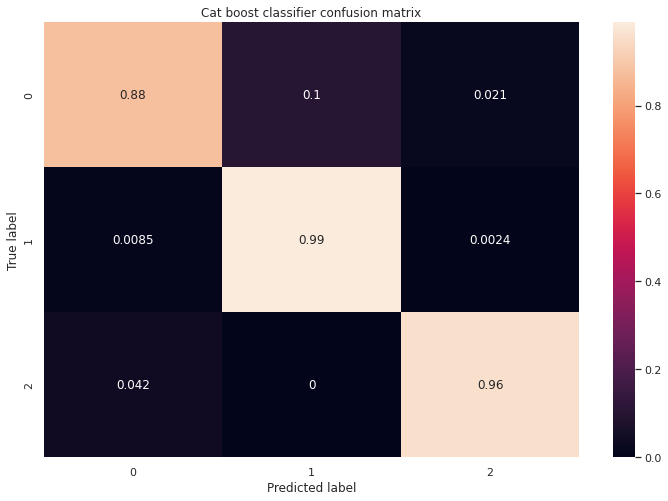

In [ ]:
conf_matrix(y_test, cat_clf.predict(X_test), 'Cat boost classifier confusion matrix')

## 2. Deep learning solution

### Data transformation

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
y_train.shape

torch.Size([2687, 1])

For validationg results while choosing the best epoch of my model I'm going to split test set on validation and test. Validation size will be half of previous test size which is 25% of dataset

In [ ]:
X_val = X_test[:len(X_test)//2, :]
X_test = X_test[len(X_test)//2:, :]
y_val = y_test[:len(y_test)//2]
y_test = y_test[len(y_test)//2:]

In [ ]:
y_train.squeeze_()
y_val.squeeze_()
y_test.squeeze_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 2., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
y_train = y_train.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

In [ ]:
X_train[:, 0]

tensor([-0.6948, -0.6948, -0.6948,  ...,  1.4821,  1.4821, -0.6948])

In [ ]:
class PartDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, X, y):
        # Save target and predictors
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


In [ ]:
train = PartDataset(X_train, y_train)
val = PartDataset(X_val, y_val)
test = PartDataset(X_test, y_test)

### Basic model

Firstly, I'll try primitive model with 2 hidden layers and neither normalization nor reguralization.

In [ ]:
def train_clf(model, n_epochs=50, batch_size=64, disable_bar=False, early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val = []
  history_tr = []
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()
      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")
      for X_batch, y_batch in loop :
          # take a batch
          # X_batch = X_train[start:start+batch_size]
          # y_batch = y_train[start:start+batch_size]
          # forward pass
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          model.get_optimizer().zero_grad()
          loss.backward()
          # update weights
          model.get_optimizer().step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
      # evaluate accuracy at end of each epoch
      model.eval()
      y_pred = model(X_val)
      y_pred_tr = model(X_train)
      loss_val = loss_fn(y_pred, y_val).item()
      history_val.append(loss_val)
      loss_tr = loss_fn(y_pred_tr, y_train).item()
      history_tr.append(loss_tr)
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if early_stop:
        if epoch > 3 and abs(history_val[-3] - history_val[-2]) < 0.001 and abs(history_val[-2] - history_val[-1]) < 0.001:
          print('')
          print('Early stop: plato found')
          break
        if epoch > 10 and (np.mean(history_val[-10: -5]) - np.mean(history_val[-5:])) < 0:
          print('')
          print('Early stop: error increasing')
          break

  return history_tr, history_val, best_weights

In [ ]:
class CLFNetwork(nn.Module):
  def __init__(self, input_len, learning_rate=0.01):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 3)
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = F.softmax(self.fc3(x))
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
def evaluate_clf(y_true, y_pred):
  f2score = fbeta_score(y_true, y_pred, beta=2, average='macro')
  print(f'F2 score = {f2score}')
  report = classification_report(y_true, y_pred, digits=3)
  print('Classification Report:')
  print(report)
  return report, f2score

In [ ]:
basic_clf = CLFNetwork(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train_clf(basic_clf, 50, 28, early_stop=True)

Epoch 0:   0%|          | 0/96 [00:00<?, ?batch/s]<ipython-input-381-c4a4c626a05e>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Epoch 20: 100%|██████████| 96/96 [00:00<00:00, 136.10batch/s, mse=0.589]



Early stop: error increasing


Best val Entropy = 0.7565543358420199


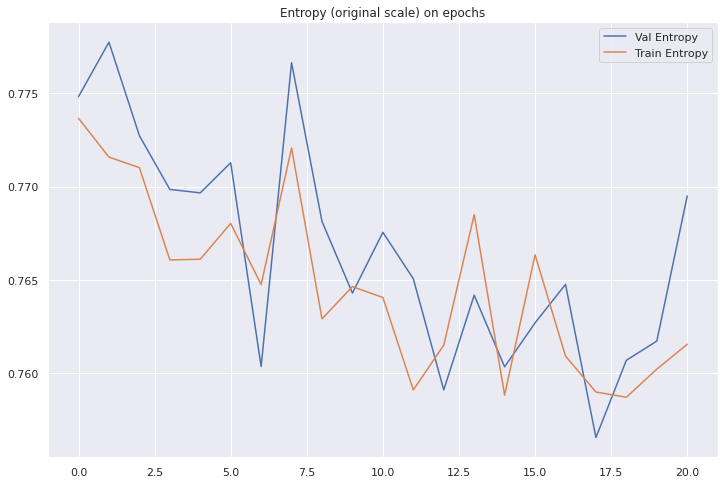

In [ ]:
basic_clf.load_state_dict(best_weights)
show_results(history_tr, history_tst, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(basic_clf(X_test), 1).detach().numpy());

F2 score = 0.7564581796663709
Classification Report:
              precision    recall  f1-score   support

           0      0.586     0.773     0.667        22
           1      0.985     0.988     0.987       410
           2      1.000     0.500     0.667        16

    accuracy                          0.960       448
   macro avg      0.857     0.754     0.773       448
weighted avg      0.966     0.960     0.959       448



<ipython-input-381-c4a4c626a05e>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


The results are ok - the entropy gets generally smaller by epochs and the result is already better then logistic regression. I'll try to add normalization to this model and the make it a bit more complicated.

### More advanced models

In [ ]:
class CLFNetworkNorm(nn.Module):
  def __init__(self, input_len=22, learning_rate=0.005, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.m2 = nn.BatchNorm1d(32)
    # self.fc3 = nn.Linear(64, 16)
    self.m1 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(32, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = self.m1(x)
     x = F.relu(self.fc2(x))
     x = self.m2(x)
    #  x = F.relu(self.fc3(x))
    #  x = self.m3(x)
     x = F.softmax(self.fc4(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
norm_clf = CLFNetworkNorm(X_train.size()[-1])

In [ ]:
history_tr, history_val, best_weights = train_clf(norm_clf, 50, 42, early_stop=True)

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 141.09batch/s, mse=0.551]



Early stop: error increasing


Best val Entropy = 0.7527522609072419


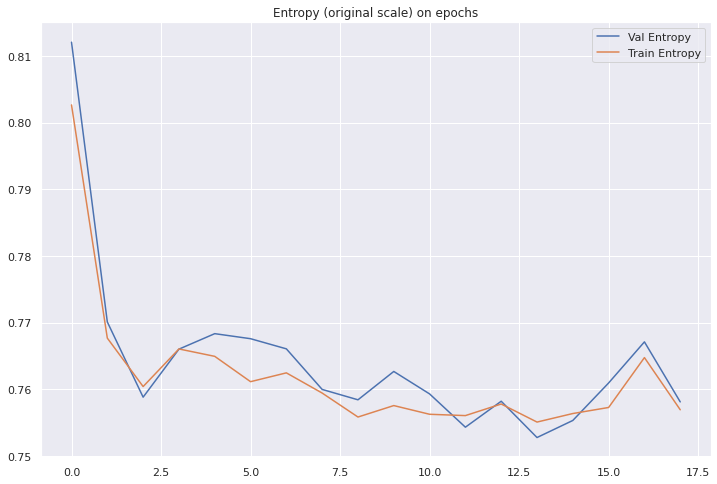

In [ ]:
norm_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(norm_clf(X_test), 1).detach().numpy());

F2 score = 0.8410115907982801
Classification Report:
              precision    recall  f1-score   support

           0      0.708     0.773     0.739        22
           1      0.983     0.985     0.984       410
           2      0.923     0.750     0.828        16

    accuracy                          0.967       448
   macro avg      0.871     0.836     0.850       448
weighted avg      0.967     0.967     0.967       448



The results got better. I'll try adding more layers.

In [ ]:
class CLFNetworkPlus(nn.Module):
  def __init__(self, input_len=22, learning_rate=0.005, weight_decay=1e-6):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.m2 = nn.BatchNorm1d(32)
    self.fc3 = nn.Linear(32, 16)
    self.m3 = nn.BatchNorm1d(16)
    #self.m1 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(16, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = F.softmax(self.fc4(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
plus_clf = CLFNetworkPlus(X_train.size()[-1])

In [ ]:
history_tr, history_val, best_weights = train_clf(plus_clf, 50, 42, early_stop=True)

Epoch 13: 100%|██████████| 64/64 [00:00<00:00, 117.50batch/s, mse=0.6]


Early stop: error increasing


Best val Entropy = 0.7501743034632882


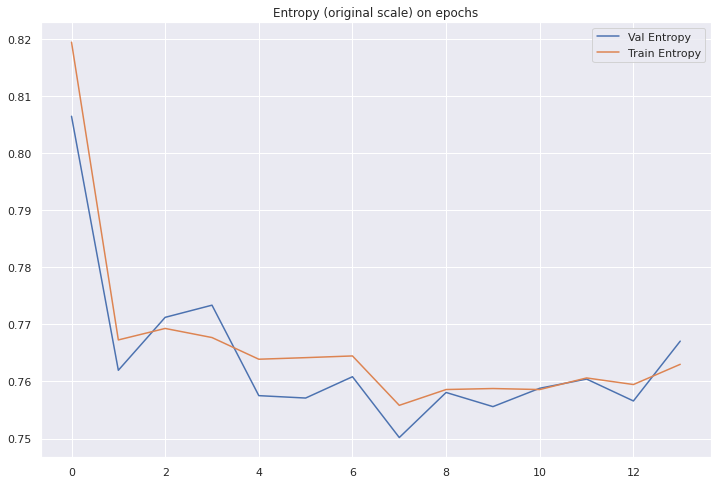

In [ ]:
plus_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(plus_clf(X_test), 1).detach().numpy());

F2 score = 0.7749635405868359
Classification Report:
              precision    recall  f1-score   support

           0      0.632     0.545     0.585        22
           1      0.974     0.988     0.981       410
           2      0.923     0.750     0.828        16

    accuracy                          0.958       448
   macro avg      0.843     0.761     0.798       448
weighted avg      0.955     0.958     0.956       448



The result didn't get better. I'll try tuning hyperparameters on previous architecture.

### Hyperparameters tuning

In [ ]:
class CLFNetworkPlusHyper(nn.Module):
  def __init__(self, input_len=22, n1=64, n2=32, learning_rate=0.005, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n1)
    self.m1 = nn.BatchNorm1d(n1)
    self.fc2 = nn.Linear(n1, n2)
    self.m2 = nn.BatchNorm1d(n2)
    # self.fc3 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(n2, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
    # self.d1 = nn.Dropout(p=p1)
    #self.d2 = nn.Dropout(p=p2)

  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = self.m1(x)
     #x = self.d1(x)
     x = F.relu(self.fc2(x))
     x = self.m2(x)
    # x = self.d2(x)
    #  x = F.relu(self.fc3(x))
    #  x = self.m3(x)
     x = F.softmax(self.fc3(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
def objective(trial):
    params_model = {'n1': trial.suggest_int('n1', 8, 128, 8),
                    'n2': trial.suggest_int('n2', 8, 64, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
                    'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1, log=True)
    }
    clf = CLFNetworkPlusHyper(X_train.size()[-1], **params_model)
    history_tr, history_val, best_weights = train_clf(clf, 50, 32, disable_bar=True)
    clf.load_state_dict(best_weights)
    clf.eval()
    score = fbeta_score(y_test.detach().numpy(), torch.argmax(clf(X_test), 1).detach().numpy(), beta=2, average='macro')
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-03-25 15:19:31,362] A new study created in memory with name: no-name-a1c73a96-e88b-43c8-8136-d5049ecf329d
/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Early stop: plato found
[I 2023-03-25 15:19:34,430] Trial 0 finished with value: 0.6994836653103448 and parameters: {'n1': 112, 'n2': 40, 'learning_rate': 0.0027053915786328887, 'weight_decay': 9.411961021000482e-06}. Best is trial 0 with value: 0.6994836653103448.

Early stop: error increasing
[I 2023-03-25 15:19:37,038] Trial 1 finished with value: 0.5942239787939665 and parameters: {'n1': 104, 'n2': 56, 'learning_rate': 0.005301500399388264, 'weight_decay': 0.050590894840381054}. Best is trial 0 with value: 0.6994836653103448.

Early stop: error increasing
[I 2023-03-25 15:19:39,798] Trial 2 finished with value: 0.7444697424311953 and parameters: {'n1': 128, 'n2': 32, 'learning_rate': 0.004711162502919193, 'weight_decay': 6.664311143676079e-08}. Best is trial 2 with value: 0.7444697424311953.

Early stop: error increasing
[I 2023-03-25 15:19:42,374] Trial 3 finished with value: 0.45970881615767767 and parameters: {'n1': 32, 'n2': 56, 'learning_rate': 0.0013722979988693164, 'weight_

In [ ]:
print('Best Validation Entropy: {}'.format(study.best_value))
print('Best Params: {}'.format(study.best_params))

Best Validation Entropy: 0.8268941064016307
Best Params: {'n1': 88, 'n2': 40, 'learning_rate': 0.0013953835417317704, 'weight_decay': 2.6988680097366353e-08}


In [ ]:
#par = {'n1': 96, 'n2': 120, 'n3': 72}
hyper_clf = CLFNetworkPlusHyper(X_train.size()[-1], **study.best_params)

In [ ]:
history_tr, history_val, best_weights = train_clf(hyper_clf, 50, 32, early_stop=False)

Epoch 49: 100%|██████████| 84/84 [00:00<00:00, 104.24batch/s, mse=0.551]


Best val Entropy = 0.7524789136169066


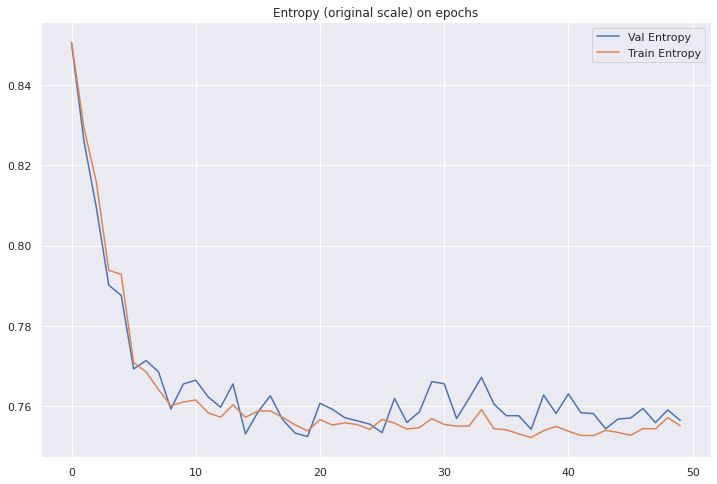

In [ ]:
hyper_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(hyper_clf(X_test), 1).detach().numpy());

F2 score = 0.7980856226470262
Classification Report:
              precision    recall  f1-score   support

           0      0.609     0.636     0.622        22
           1      0.981     0.985     0.983       410
           2      0.923     0.750     0.828        16

    accuracy                          0.960       448
   macro avg      0.837     0.791     0.811       448
weighted avg      0.960     0.960     0.960       448



Hyperparameters tuning didn't give much results so the best model is earlier one which has 0.84 f2 macro score. This result is better then common logistic regression solution by abou 10%, but is much worse then gradient boost classifier. Perhaps to create good DL model on tabular data we need more samples.

## 3. Conclusions

I've preformed 3 types of task using deep learning methods: regression, classification and computer vision. On tablar data tasks the achieved results were better then common linear or logistic regression but in both cases were worse that gradient boosting. In case of CV, achieved results appeared relatively good, although significantly worse than in case of using pretrained models. Those, combined with trained by myself final layer gave the best results. I think that the main limitation in this part was the dataset - I  coudn't achieve stable results and so my models tended to overfit. Perhaps with bigger dataset resulting accuracy woud have been higher.